# Image classification project - Deep Learning Project 2023

Authors: Lauri Vuorenkoski & Juho Hotari

Data: https://www.cs.helsinki.fi/Roman.Yangarber/Courses/2023-deep-learning/image-training-corpus+annotations/

Data should be in projectData folder.

In [1]:
import csv
from PIL import Image
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
import numpy as np
import time
from sklearn.metrics import precision_recall_fscore_support

In [2]:
# 14 labels:
label_names = ['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 
               'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']

# Training dataset is 20,000 RGB images size 128x128
image_count = 20000
image_size = 128
label_count = len(label_names)
label_path = 'annotations/'
image_path = 'images/'
train_size = 16000
dev_size = 2000
test_size = image_count - train_size - dev_size
batch_size = 20
epoch_count = 70 # number of epochs passed in one run
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using device:',torch.cuda.get_device_name(0))
    print(f'Total memory: ',
          f'{torch.cuda.get_device_properties(0).total_memory / (1024*1024*1024):.1f} GB')
else:
    print('Using device: CPU')

Using device: Tesla V100-SXM2-32GB
Total memory:  31.7 GB


In [3]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Read labels

This prudeces a tensor with rows as a cases and 28 columns as indicating labels. 0=non-baby, 1=baby, 2=non-bird...

In [4]:
labels = torch.zeros((image_count,label_count*2), dtype=int)
labelc = np.zeros(label_count, dtype='int')
label_weights = torch.zeros(label_count*2, dtype=float)
for i in range(image_count):
    for j in range(label_count):
        labels[i][(j * 2)] = 1

print('\nNUMBER OF LABELS IN DATA-SET\n\nLabel    Count')
for id, label in enumerate(label_names):
    with open(label_path + label + '.txt') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        c = 0
        for row in csv_reader:
            c += 1
            labels[int(row[0]) - 1][id * 2]=0
            labels[int(row[0]) - 1][(id * 2) + 1]=1
        labelc[id] = c
        label_weights[id * 2] = (c / image_count)
        label_weights[id * 2 + 1] = 1 - (c / image_count)
        print(f'{label:<8} {c/image_count:.3f} {c}')

c=np.zeros(7, dtype=int)
for i in range(image_count):
    cc = 0
    for j in range(label_count):
        if labels[i][(j * 2) + 1]==1:
            cc += 1
    c[cc] += 1
print('\nCount of tags in images (0-7):')
print(c)


NUMBER OF LABELS IN DATA-SET

Label    Count
baby     0.005 95
bird     0.018 360
car      0.016 319
clouds   0.055 1095
dog      0.022 448
female   0.161 3227
flower   0.038 761
male     0.149 2979
night    0.030 598
people   0.320 6403
portrait 0.156 3121
river    0.006 120
sea      0.009 173
tree     0.026 525

Count of tags in images (0-7):
[9824 4161 2388 3230  388    9    0]


So about half of the images do not have any label, and about 3500 have more than two labels

## Read images

All images are read to the memory. Part of the images are grayscale, in that case 1D->3d conversion

In [5]:
start = time.time()
convert_tensor = transforms.ToTensor()
images = torch.zeros((image_count, 3, image_size, image_size), dtype=torch.float)
bw = 0
for i in range(image_count):
    with Image.open(image_path + 'im' + str(i + 1) + '.jpg') as img:
        tensor = convert_tensor(img) * 2 - 1
        if tensor.shape[0]==1: # Part of the images are gray scale, 1D->3D
            tensor = torch.stack((tensor[0],tensor[0],tensor[0]),0)
            bw += 1
        images[i] = tensor
print('Image count:',len(images))
print('Grayscale images:',bw)
end = time.time()
print('Processing time (s): ', end-start)

Image count: 20000
Grayscale images: 1422
Processing time (s):  854.3356690406799


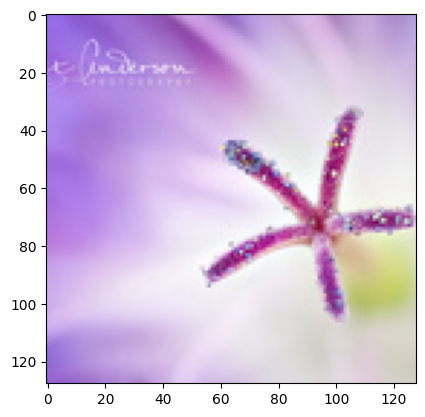

In [13]:
# Plot one image based on index:

imshow(images[44])

###### Loaders

Labels and images are grouped together anf randomly divided to train, development and test sets.

In [6]:
data = []
for i,x in enumerate(images):
    data.append([x,labels[i]])
train, dev, test = torch.utils.data.random_split(data,[train_size, dev_size, test_size])
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
devloader = torch.utils.data.DataLoader(dev, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size)

## Build classifier

This block initalises epoch count and datastructers for collecting performance data during epochs.

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()                                             # 2D size after layer
        self.conv1 = nn.Conv2d(3, 24, kernel_size = 3, padding = 1)    # 128x128
        self.pool1 = nn.MaxPool2d(2, 2)                                # 64x64
        self.conv2 = nn.Conv2d(24, 48, kernel_size = 3, padding = 1)   # 64x64
        self.pool2 = nn.MaxPool2d(2, 2)                                # 32x32
        self.conv3 = nn.Conv2d(48, 96, kernel_size = 3, padding = 1)   # 32x32
        self.pool3 = nn.MaxPool2d(2, 2)                                # 16x16
        self.conv4 = nn.Conv2d(96, 192, kernel_size = 3, padding = 1)  # 16x16
        self.pool4 = nn.MaxPool2d(2, 2)                                # 8x8
        self.fc1 = nn.Linear(192 * 8 * 8, 1024) 
        self.fc2 = nn.Linear(1024, 512) 
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 28)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

net = Net().to(device)
epoch = 0
loss_train = []
loss_dev = []
sn_dev = []
sp_dev = []
acc_dev = []
sn_train = []
sp_train = []
acc_train = []
epoch_round=[]

#summary(net, input_size=(batch_size, 3, 128, 128)) # works only with torchinfo package

In [8]:
label_weights = label_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=label_weights)
optimizer = torch.optim.SGD(net.parameters(), lr=0.005, momentum=0.7)

## Train model

Next block can be run several times one after the anothers. It starts from the state where previous run ended. 

Epoch 1: train-loss: 0.2454, train-acc: 0.44, dev-loss: 0.2306, dev-acc: 0.66, dev-sens:0.68, dev-spec:0.66, F1-macro:0.084, F1-micro:0.217
Epoch 2: train-loss: 0.2343, train-acc: 0.55, dev-loss: 0.2305, dev-acc: 0.41, dev-sens:0.90, dev-spec:0.37, F1-macro:0.107, F1-micro:0.174
Epoch 3: train-loss: 0.2339, train-acc: 0.53, dev-loss: 0.2296, dev-acc: 0.65, dev-sens:0.39, dev-spec:0.67, F1-macro:0.100, F1-micro:0.134
Epoch 4: train-loss: 0.2330, train-acc: 0.60, dev-loss: 0.2280, dev-acc: 0.58, dev-sens:0.63, dev-spec:0.58, F1-macro:0.135, F1-micro:0.172
Epoch 5: train-loss: 0.2314, train-acc: 0.60, dev-loss: 0.2266, dev-acc: 0.59, dev-sens:0.48, dev-spec:0.59, F1-macro:0.136, F1-micro:0.139
Epoch 6: train-loss: 0.2289, train-acc: 0.61, dev-loss: 0.2228, dev-acc: 0.65, dev-sens:0.58, dev-spec:0.66, F1-macro:0.173, F1-micro:0.187
Epoch 7: train-loss: 0.2261, train-acc: 0.63, dev-loss: 0.2231, dev-acc: 0.63, dev-sens:0.44, dev-spec:0.65, F1-macro:0.158, F1-micro:0.142
Epoch 8: train-loss:

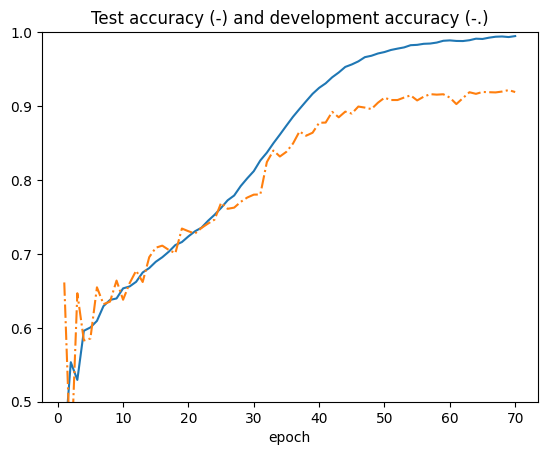

In [14]:
transform = transforms.Compose([transforms.RandomRotation(20)])

start = time.time()
for i in range(epoch_count):
    epoch += 1
    train_loss = 0.0
    train_correct = 0
    tp = 0
    fn = 0
    fp = 0
    tn = 0
    for i, data in enumerate(trainloader, 0):
        net.train()
        inputs, labs = data
        inputs = inputs.to(device)
        labs = labs.to(device)

        # Transform
        inputs = transform(inputs)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labs.type(torch.float))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        labs = labs.cpu().detach().numpy()
        outputs = outputs.cpu().detach().numpy()
        for i in range(len(labs)):
            for j in range(label_count):
                predicted = np.argmax([outputs[i][j * 2], outputs[i][(j * 2) + 1]])
                true_class = np.argmax([labs[i][j * 2], labs[i][(j * 2) + 1]])
                if true_class==1 and predicted==1:
                    tp += 1
                    train_correct += 1
                if true_class==1 and predicted==0:
                    fn += 1
                if true_class==0 and predicted==1:
                    fp += 1
                if true_class==0 and predicted==0:
                    tn += 1
                    train_correct += 1
    loss_train.append(train_loss / train_size)
    acc_train.append(train_correct / (train_size * label_count))
    sn_t = tp / (tp + fn)
    sp_t = tn / (tn + fp)
    sn_train.append(sn_t)
    sp_train.append(sp_t)

    # Validate
    dev_loss = 0
    dev_correct = 0
    tp = 0
    fn = 0
    fp = 0
    tn = 0
    y_true = np.zeros((dev_size,label_count), dtype='int')
    y_pred = np.zeros((dev_size,label_count), dtype='int')
    k = 0
    with torch.no_grad():
        for data in devloader:
            net.eval()
            inputs, labs = data
            inputs = inputs.to(device)
            labs = labs.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labs.type(torch.float))
                       
            dev_loss += loss.item()
            labs = labs.cpu().detach().numpy()
            outputs = outputs.cpu().detach().numpy()
            for i in range(len(labs)):
                for j in range(label_count):
                    predicted = np.argmax([outputs[i][j * 2], outputs[i][(j * 2) + 1]])
                    true_class = np.argmax([labs[i][j * 2], labs[i][(j * 2) + 1]])
                    y_true[i + k * batch_size,j] = true_class
                    y_pred[i + k * batch_size,j] = predicted
                    if true_class==1 and predicted==1:
                        tp += 1
                        dev_correct += 1
                    if true_class==1 and predicted==0:
                        fn += 1
                    if true_class==0 and predicted==1:
                        fp += 1
                    if true_class==0 and predicted==0:
                        tn += 1
                        dev_correct += 1
            k += 1            
    sn_d = tp / (tp + fn)
    sp_d = tn / (tn + fp)
    prec, recall, f1_macro, support = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    prec, recall, f1_micro, support = precision_recall_fscore_support(y_true, y_pred, average='micro')
    print(f'Epoch {epoch}: train-loss: {train_loss / train_size:.4f}, train-acc: ' + 
          f'{train_correct / (train_size * label_count):.2f}, dev-loss: {dev_loss / dev_size:.4f}, ' +
          f'dev-acc: {dev_correct / (dev_size * label_count):.2f}, dev-sens:{sn_d:.2f}, dev-spec:{sp_d:.2f}, F1-macro:{f1_macro:.3f}, F1-micro:{f1_micro:.3f}')
    loss_dev.append(dev_loss / dev_size)
    acc_dev.append(dev_correct / (dev_size * label_count))
    sn_dev.append(sn_d)
    sp_dev.append(sp_d)
    epoch_round.append(epoch)
print('Finished Training')
end = time.time()
print('Time elapsed:',int(end - start),'seconds\n')

plt.plot(epoch_round,acc_train)
plt.plot(epoch_round,acc_dev, '-.')
plt.xlabel('epoch')
plt.ylim([0.5, 1.0])
plt.title('Test accuracy (-) and development accuracy (-.)')
plt.show()

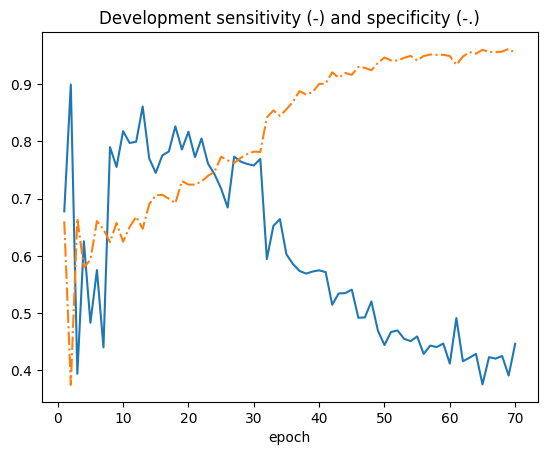

In [15]:
plt.plot(epoch_round,sn_dev)
plt.plot(epoch_round,sp_dev, '-.')
plt.xlabel('epoch')
plt.title('Development sensitivity (-) and specificity (-.)')
plt.show()

## Test model

In [16]:
tp = np.zeros(label_count, dtype='int')
fp = np.zeros(label_count, dtype='int')
tn = np.zeros(label_count, dtype='int')
fn = np.zeros(label_count, dtype='int')
y_true = np.zeros((test_size,label_count), dtype='int')
y_pred = np.zeros((test_size,label_count), dtype='int')
labelc = np.zeros(label_count, dtype='int')

k = 0;
for data in testloader:
    ims, labs = data
    labs = labs.detach().numpy()
    net.eval()
    outputs = net(ims.to(device)).cpu().detach().numpy()
    for i in range(batch_size):
        for j in range(label_count):
            predicted = np.argmax([outputs[i][j*2], outputs[i][(j*2)+1]])
            true_class = np.argmax([labs[i][j*2], labs[i][(j*2)+1]])
            y_true[i + k * batch_size,j] = true_class
            y_pred[i + k * batch_size,j] = predicted
            labelc[j] += true_class
            if true_class==1 and predicted==1:
                tp[j] += 1
            if true_class==1 and predicted==0:
                fn[j] += 1
            if true_class==0 and predicted==1:
                fp[j] += 1
            if true_class==0 and predicted==0:
                tn[j] += 1
    k += 1

print('\nRESULTS WITH TEST SET')
print('\nLabel     Accuracy  sens    spec    F1       F1-dummy  labels in test data ')
for i in range(label_count):
    p = labelc[i] / test_size
    prec = tp[i]/(tp[i]+fp[i])
    recall = tp[i]/(tp[i]+fn[i])
    print(f'{label_names[i]:<8}  {(tp[i]+tn[i]) / test_size:.2f}      {tp[i] / (tp[i] + fn[i]):.2f}' +
          f'    {tn[i] / (tn[i] + fp[i]):.2f}    {2*prec*recall/(prec+recall):.3f}    {2 * p / (p+1):.3f}     {labelc[i]}   ')
print(f'\nAccuracy:    {(tp.sum() + tn.sum()) / (test_size * label_count):.2f}')
print(f'Sensitivity: {tp.sum() / (tp.sum() + fn.sum()):.2f}')
print(f'Specificity: {tn.sum() / (tn.sum() + fp.sum()):.2f}\n')
prec, recall, f1_macro, support = precision_recall_fscore_support(y_true, y_pred, average='macro')
prec, recall, f1_micro, support = precision_recall_fscore_support(y_true, y_pred, average='micro')
print(f'F1-macro: {f1_macro:.3f}')
print(f'F1-micro: {f1_micro:.3f}\n')


RESULTS WITH TEST SET

Label     Accuracy  sens    spec    F1       F1-dummy  labels in test data 
baby      0.99      0.29    0.99    0.174    0.007     7   
bird      0.97      0.03    0.99    0.034    0.035     36   
car       0.98      0.21    0.99    0.222    0.029     29   
clouds    0.93      0.51    0.96    0.448    0.100     105   
dog       0.95      0.16    0.97    0.135    0.043     44   
female    0.80      0.42    0.87    0.397    0.268     309   
flower    0.95      0.30    0.98    0.351    0.087     91   
male      0.79      0.36    0.86    0.325    0.239     272   
night     0.96      0.38    0.97    0.304    0.049     50   
people    0.73      0.58    0.80    0.566    0.467     609   
portrait  0.84      0.48    0.91    0.484    0.268     310   
river     0.99      0.06    0.99    0.069    0.018     18   
sea       0.98      0.12    0.98    0.075    0.017     17   
tree      0.96      0.12    0.98    0.146    0.054     56   

Accuracy:    0.92
Sensitivity: 0.44
Speci

In [17]:
print(f'Accuracy if are classified as 0:  {1-(labelc.sum()/(label_count*test_size)):.2f}')

y_pred = np.ones((test_size,label_count), dtype='int')

prec, recall, f1_macro, support = precision_recall_fscore_support(y_true, y_pred, average='macro')
prec, recall, f1_micro, support = precision_recall_fscore_support(y_true, y_pred, average='micro')
print('Dummy classifier')
print(f'F1-macro: {f1_macro:.3f}')
print(f'F1-micro: {f1_micro:.3f}\n')

Accuracy if are classified as 0:  0.93
Dummy classifier
F1-macro: 0.120
F1-micro: 0.130



## Seperate test set

In [18]:
imaget_path = 'test_data/images/'
imaget_count = 5000
start_label = 20001

In [19]:
start = time.time()
images2 = torch.zeros((imaget_count, 3, image_size, image_size), dtype=torch.float)
filename = torch.zeros((imaget_count), dtype=int)
bw = 0

for i in range(imaget_count):
    with Image.open(imaget_path + 'im' + str(i + start_label) + '.jpg') as img:
        tensor = convert_tensor(img) * 2 - 1
        filename[i] = i + start_label
        if tensor.shape[0]==1: # Part of the images are gray scale, 1D->3D
            tensor = torch.stack((tensor[0],tensor[0],tensor[0]),0)
            bw += 1
        images2[i] = tensor
print('Image count:',len(images2))
print('Grayscale images:',bw)
end = time.time()
print('Processing time (s): ', end-start)

Image count: 5000
Grayscale images: 316
Processing time (s):  164.0393943786621


In [20]:
data2 = []
for i,x in enumerate(images2):
    data2.append([x,filename[i]])
testloader2 = torch.utils.data.DataLoader(data2, batch_size=batch_size)

In [25]:
y_pred = np.zeros((imaget_count,label_count), dtype='int')
fn = np.zeros((imaget_count), dtype='int')
labelct = np.zeros(label_count, dtype='int')

k = 0;
outs = []
for data in testloader2:
    ims, filename = data
    filename = filename.detach().numpy()
    net.eval()
    outputs = net(ims.to(device)).cpu().detach().numpy()
    outs.append(outputs)
    for i in range(batch_size):
        for j in range(label_count):
            predicted = np.argmax([outputs[i][j*2], outputs[i][(j*2)+1]])
            y_pred[i + k * batch_size,j] = predicted
            fn[i + k * batch_size] = filename[i]
            if predicted==1:
                labelct[j] += 1
                
    k += 1

print('\nRESULTS WITH SEPERATE TEST SET')
print('\nLabel     predicted labels')
for i in range(label_count):
    print(f'{label_names[i]:<8}  {labelct[i]/imaget_count:.3f}   {labelct[i]}   ')


RESULTS WITH SEPERATE TEST SET

Label     predicted labels
baby      0.008   40   
bird      0.019   95   
car       0.014   71   
clouds    0.063   317   
dog       0.032   162   
female    0.156   779   
flower    0.041   206   
male      0.163   815   
night     0.029   143   
people    0.297   1487   
portrait  0.147   735   
river     0.005   25   
sea       0.020   102   
tree      0.021   104   


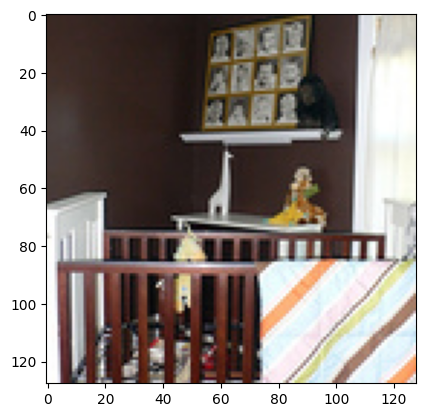

Predicted labels:  []


In [45]:
# Plot one test image and predicted labels:

index = 1234 # change value to plot a specific image 

imshow(images2[index])

predicted = []
for i in range(len(label_names)):
    if y_pred[index][i] == 1:
        predicted.append(label_names[i])
print('Predicted labels: ', predicted)

In [45]:
with open('predictions.tsv', 'w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t', lineterminator='\n')
    writer.writerow(['Filename'] + label_names)
    for i in range(imaget_count):
        writer.writerow(np.concatenate(([fn[i]], y_pred[i])))

In [40]:
c=np.zeros(14, dtype=int)
for i in range(imaget_count):
    cc = 0
    for j in range(label_count):
        if y_pred[i][j]==1:
            cc += 1
    c[cc] += 1
print('\nCount of tags in images (0-7):')
print(c)


Count of tags in images (0-7):
[2489 1066  609  580  229   21    6    0    0    0    0    0    0    0]


## Distribution in test set

In [41]:
labelct = np.zeros(label_count, dtype='int')

k = 0;
for data in testloader:
    ims, filename = data
    filename = filename.detach().numpy()
    net.eval()
    outputs = net(ims.to(device)).cpu().detach().numpy()
    for i in range(batch_size):
        for j in range(label_count):
            predicted = np.argmax([outputs[i][j*2], outputs[i][(j*2)+1]])
            if predicted==1:
                labelct[j] += 1
    k += 1
    
print('\nRESULTS WITH SPLITTED TEST SET')
print('\nLabel     predicetd labels')
for i in range(label_count):
    print(f'{label_names[i]:<8}  {labelct[i]/test_size:.3f}   {labelct[i]}   ')


RESULTS WITH SPLITTED TEST SET

Label     predicetd labels
baby      0.008   16   
bird      0.011   23   
car       0.013   25   
clouds    0.068   136   
dog       0.030   60   
female    0.171   341   
flower    0.032   63   
male      0.169   338   
night     0.037   75   
people    0.316   632   
portrait  0.155   310   
river     0.005   11   
sea       0.018   36   
tree      0.020   40   
